# Synthetic data test: Effect of random noise on the solution

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

In [2]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly_noiseless = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level

In [3]:
noise_levels = [0, 2.5, 5, 7.5, 10, 15, 20, 25, 30]
noisy_data = {}
for noise in noise_levels:
    magnetic_anomaly = (
        magnetic_anomaly_noiseless 
        + np.random.default_rng(42).normal(0, noise, size=magnetic_anomaly_noiseless.shape)
    )
    # Make a grid and calculate derivatives
    # Can't have the height as a coordinate because of a problem with xrft
    data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
    data["deriv_east"] = hm.derivative_easting(data.field)
    data["deriv_north"] = hm.derivative_northing(data.field)
    pad_width = {
        "easting": data.easting.size // 3,
        "northing": data.northing.size // 3,
    }
    padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
    data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
    # Add back the height
    data = data.assign_coords(height=data.height)
    noisy_data[noise] = data

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site

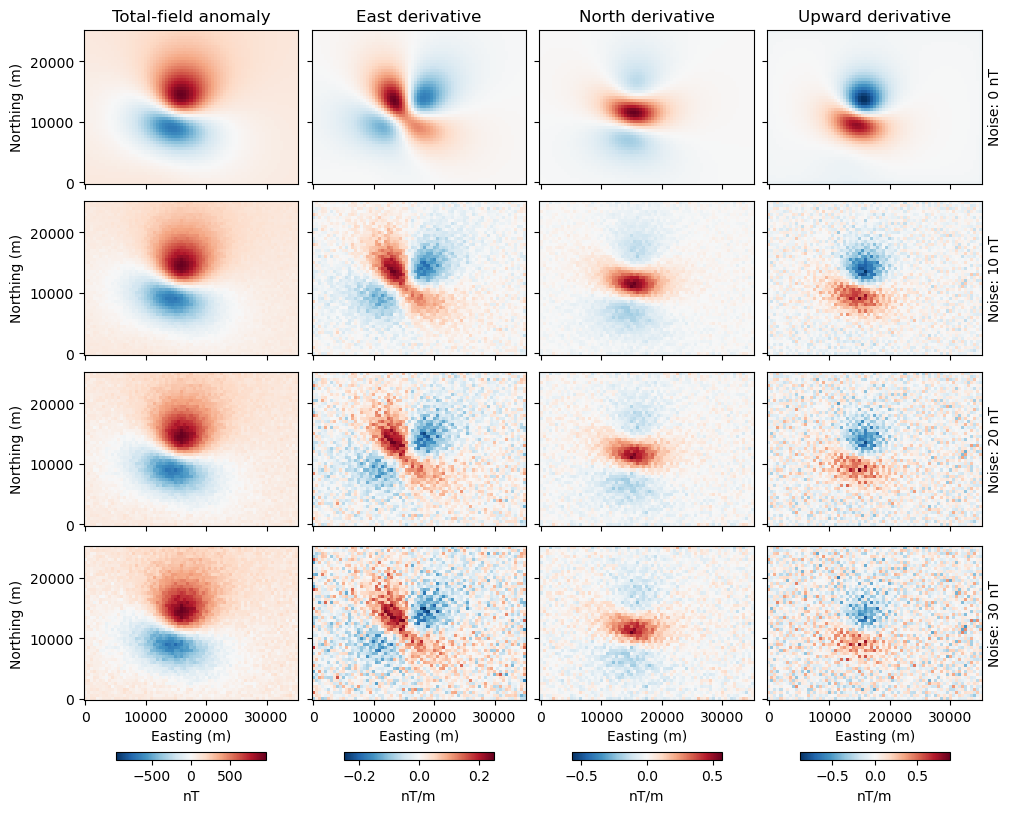

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8), layout='constrained', sharex=True, sharey=True)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
titles = {"field": "Total-field anomaly", "deriv_east": "East derivative", "deriv_north": "North derivative", "deriv_up": "Upward derivative"}
noise_to_plot = [0, 10, 20, 30]
for i, noise in enumerate(noise_to_plot):
    for field, ax in zip(titles, axes[i, :].ravel()):
        if i == axes.shape[0] - 1:
            kwargs = dict(add_colorbar=True, cbar_kwargs=dict(orientation="horizontal", aspect=20, shrink=0.7, label=units[field]))
        else:
            kwargs = dict(add_colorbar=False)
        noisy_data[noise][field].plot.pcolormesh(ax=ax, add_labels=False, **kwargs)
        ax.set_aspect("equal")
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, noise in zip(axes[:, -1], noise_to_plot):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Noise: {noise} nT")
for ax, field in zip(axes[0, :], titles):
    ax.set_title(titles[field])
plt.show()

In [5]:
estimates_ei = {}
estimates_ed = {}
for noise in noisy_data:
    data = noisy_data[noise]
    ei = euler.EulerInversion(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    estimates_ei[noise] = ei    
    ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    estimates_ed[noise] = ed

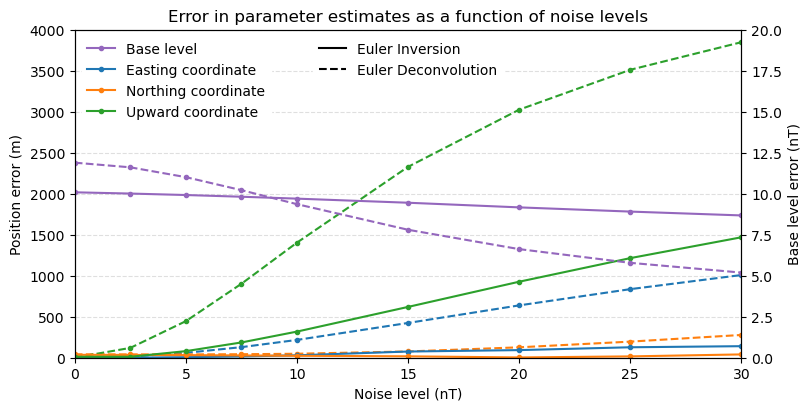

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
twin = ax1.twinx()

colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for estimates, style in zip([estimates_ed, estimates_ei], ["--", "-"]):
    error_position = []
    error_baselevel = []
    for noise in estimates:
        ei = estimates[noise]
        error_position.append(
            np.abs(np.array(true_coordinates) - ei.source_location_)
        )
        error_baselevel.append(base_level - ei.base_level_)
    error_position = np.array(error_position)

    east, = ax1.plot(noise_levels, error_position[:, 0], color=colors[0], linestyle=style, marker=".")
    north, = ax1.plot(noise_levels, error_position[:, 1], color=colors[1], linestyle=style, marker=".")
    up, = ax1.plot(noise_levels, error_position[:, 2], color=colors[2], linestyle=style, marker=".")
    base, = twin.plot(noise_levels, error_baselevel, color=colors[4], linestyle=style, marker=".")

ax1.grid(axis="y", alpha=0.4, linestyle="--")
ax1.legend(
    [base, east, north, up], 
    ["Base level", "Easting coordinate", "Northing coordinate", "Upward coordinate"],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
inversion, = ax1.plot([], [], "-k")
deconv, = ax1.plot([], [], "--k")
twin.legend(
    [inversion, deconv], 
    ["Euler Inversion", "Euler Deconvolution"], 
    loc="upper center",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
twin.set_ylabel("Base level error (nT)")
twin.set_ylim(0, 20)
ax1.set_ylim(0, 4000)
ax1.set_xlim(min(noise_levels), max(noise_levels))
ax1.set_xlabel("Noise level (nT)")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in parameter estimates as a function of noise levels")

plt.show()